In [1]:
import pandas as pad 
import numpy as np
from numpy.core.numeric import NaN

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import statistics
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind


import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as multi 

from sklearn.preprocessing import StandardScaler, OneHotEncoder



from joblib import dump, load

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV

from sklearn.preprocessing import *
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.metrics import  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve

In [2]:
df           = pad.read_excel('DATA_IA_CQ_Halcyon.xlsx')
list_to_drop = ['ID Patient', 'Nom du Case', 'G_2.5/2.5', 'G_3/3', 'G_2/3', 'G_2/2.5', 'G_3/2', 'ID faisceau ']
df_drop      = df.drop(list_to_drop, axis =1)
df_drop

/home/aurelien/anaconda3/envs/Tensorflow/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


,SAS10,MCSV,BA,BI,BM,BRAS,COLLI,Class_2.5/2.5,Class_3/3,Class_3/2,Class_2/3,Class_2/2.5
0,0.1204,0.2804,53.6566,5.3776,0.6849,129,345,0,1,0,1,0
1,0.1278,0.3143,52.8479,5.9211,0.6681,121,345,1,1,1,1,1
2,0.1572,0.3698,66.5478,6.4784,0.6078,305,20,1,1,1,1,1
3,0.1572,0.3698,66.5478,6.4784,0.6078,305,20,1,1,1,1,1
4,0.0457,0.4849,28.3954,2.9551,0.4953,235,15,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.0886,0.4837,16.4291,3.0396,0.4940,345,12,1,1,1,1,1
314,0.1169,0.3234,63.3976,5.9473,0.6636,140,350,0,1,0,1,0
315,0.1177,0.4071,74.6656,5.8371,0.5740,135,350,0,1,0,1,0
316,0.1082,0.3832,61.8779,5.7322,0.6037,301,10,1,1,1,1,1


In [3]:
to_predict_features = ['Class_2.5/2.5', 'Class_3/3', 'Class_3/2', 'Class_2/3', 'Class_2/2.5']

Y = df_drop[to_predict_features]
X = df_drop.drop(to_predict_features, axis = 1)

In [4]:
for i in range (len(to_predict_features)) :
    counts = df_drop[to_predict_features[i]].value_counts()
    print(counts)

1    220
0     98
Name: Class_2.5/2.5, dtype: int64
1    315
0      3
Name: Class_3/3, dtype: int64
1    203
0    115
Name: Class_3/2, dtype: int64
1    311
0      7
Name: Class_2/3, dtype: int64
1    175
0    143
Name: Class_2/2.5, dtype: int64


## Exploration des données

In [ ]:
sns.pairplot(df_drop, hue='Class_2/2.5', height=2.5)

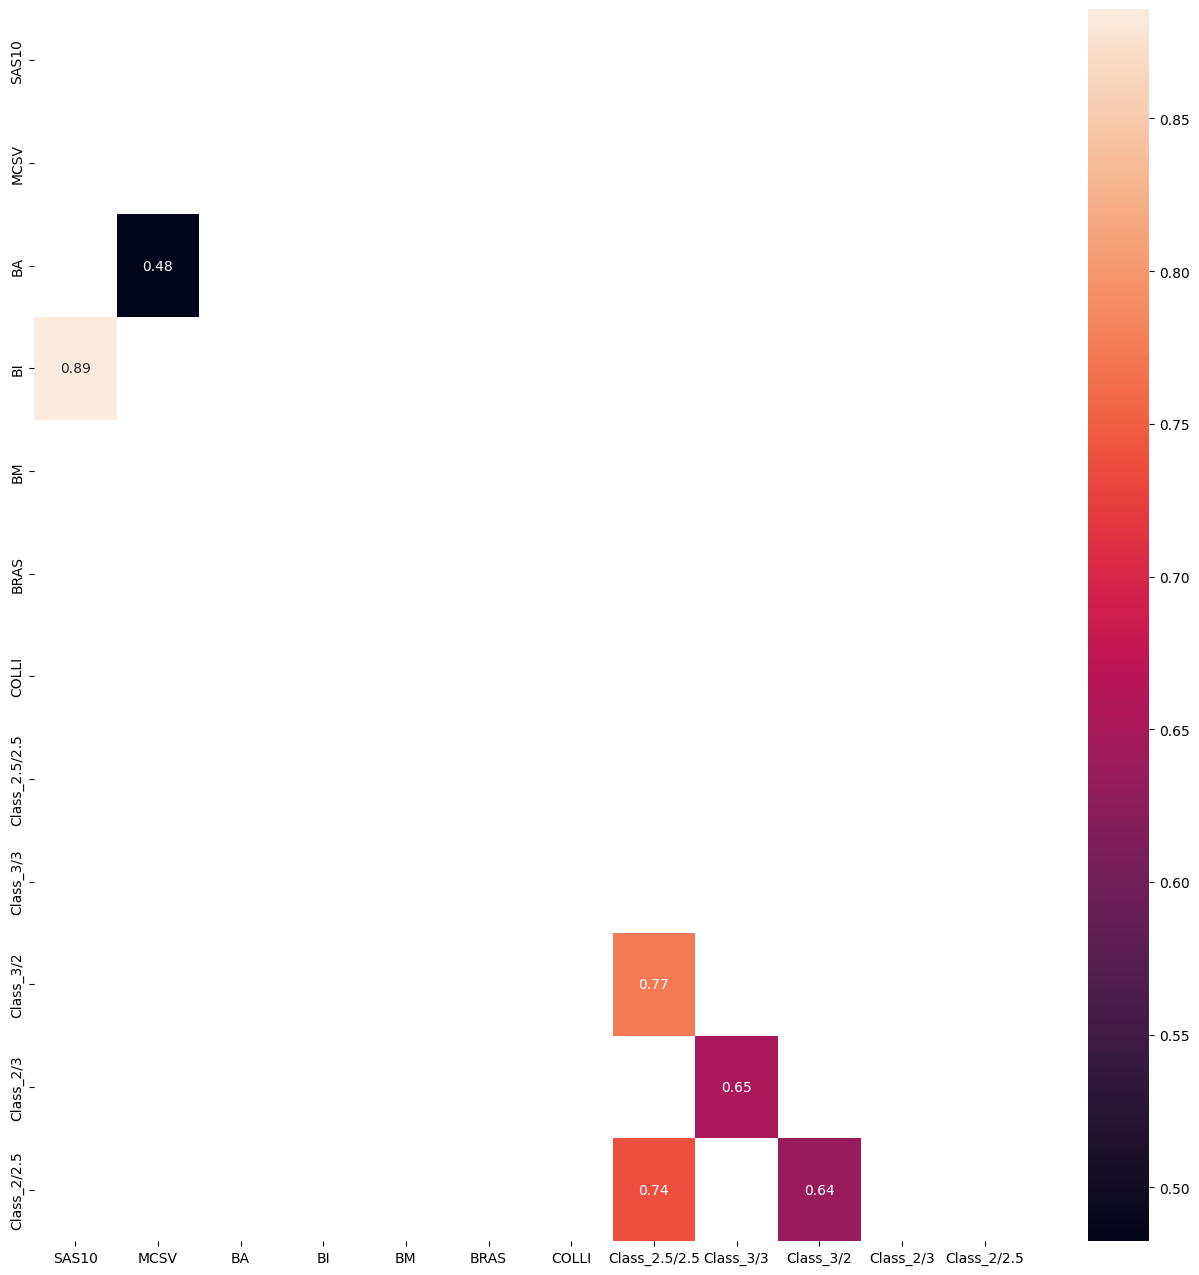

In [5]:
dfQ = df_drop
def corr_corr(df=None):
	corr = np.zeros(shape=(dfQ.shape[1],dfQ.shape[1]))
	for col in dfQ.columns:
		for col2 in dfQ.drop(col,axis=1).columns:
			c , p = stats.pearsonr(dfQ[col],dfQ[col2])
			corr[dfQ.columns.to_list().index(col),dfQ.columns.to_list().index(col2)] = c
	return corr


def corr_pvalue(df=None):
	p_matrix = np.zeros(shape=(dfQ.shape[1],dfQ.shape[1]))
	for col in dfQ.columns:
		for col2 in dfQ.drop(col,axis=1).columns:
			c , p = stats.pearsonr(dfQ[col],dfQ[col2])
			p_matrix[dfQ.columns.to_list().index(col),dfQ.columns.to_list().index(col2)] = p
	return p_matrix


p_values = corr_pvalue(dfQ)                   # get p-values
corr = corr_corr(dfQ)                     # get R values
maskP = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr
maskR = np.invert(np.tril(corr>0.45))
mask = maskP + maskR

plt.figure(figsize=(16, 16))
ax = sns.heatmap(dfQ.corr(), mask=mask, annot=True)
figure_pvalue_corr = ax.get_figure()
#figure_pvalue_corr.savefig("heatmap_quantitative_variables_pvalue_corr", dpi=400)

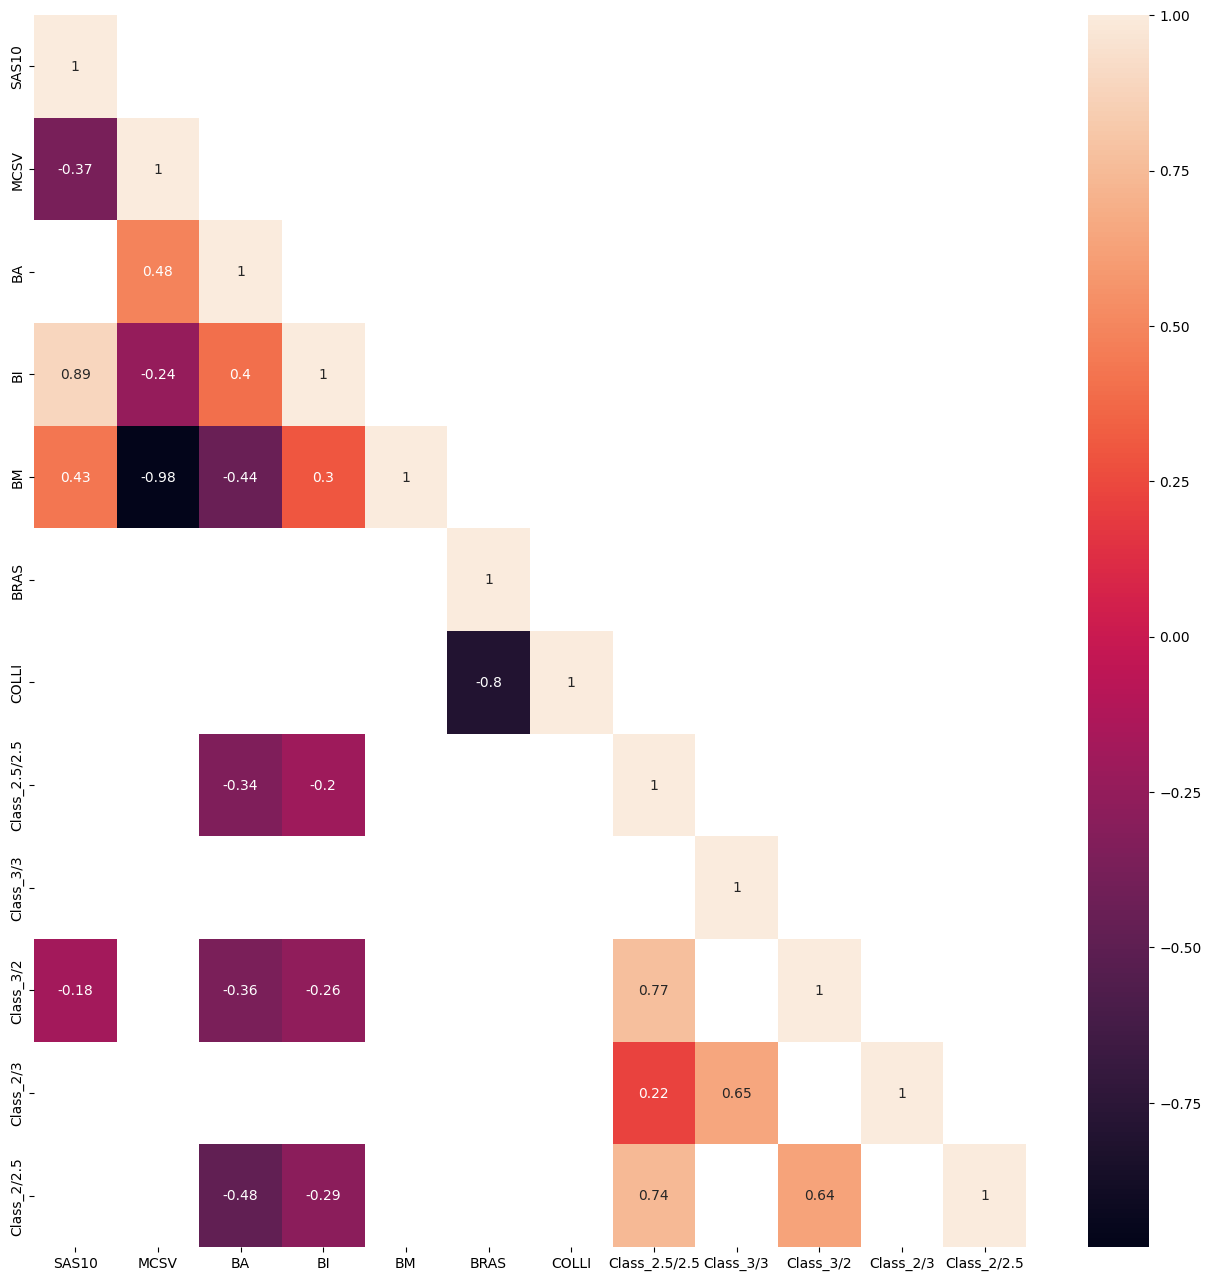

In [6]:
def corr_sig(df=None):
	p_matrix = np.zeros(shape=(dfQ.shape[1],dfQ.shape[1]))
	for col in dfQ.columns:
		for col2 in dfQ.drop(col,axis=1).columns:
			_ , p = stats.pearsonr(dfQ[col],dfQ[col2])
			p_matrix[dfQ.columns.to_list().index(col),dfQ.columns.to_list().index(col2)] = p
	return p_matrix

p_values = corr_sig(dfQ)                     # get p-Value
mask = np.invert(np.tril(p_values<0.001))    # mask - only get significant corr

plt.figure(figsize=(16, 16))
ax = sns.heatmap(dfQ.corr(), mask=mask, annot=True)
figure_pvalue= ax.get_figure()
figure_pvalue.savefig("heatmap_quantitative_variables_pvalue", dpi=400)

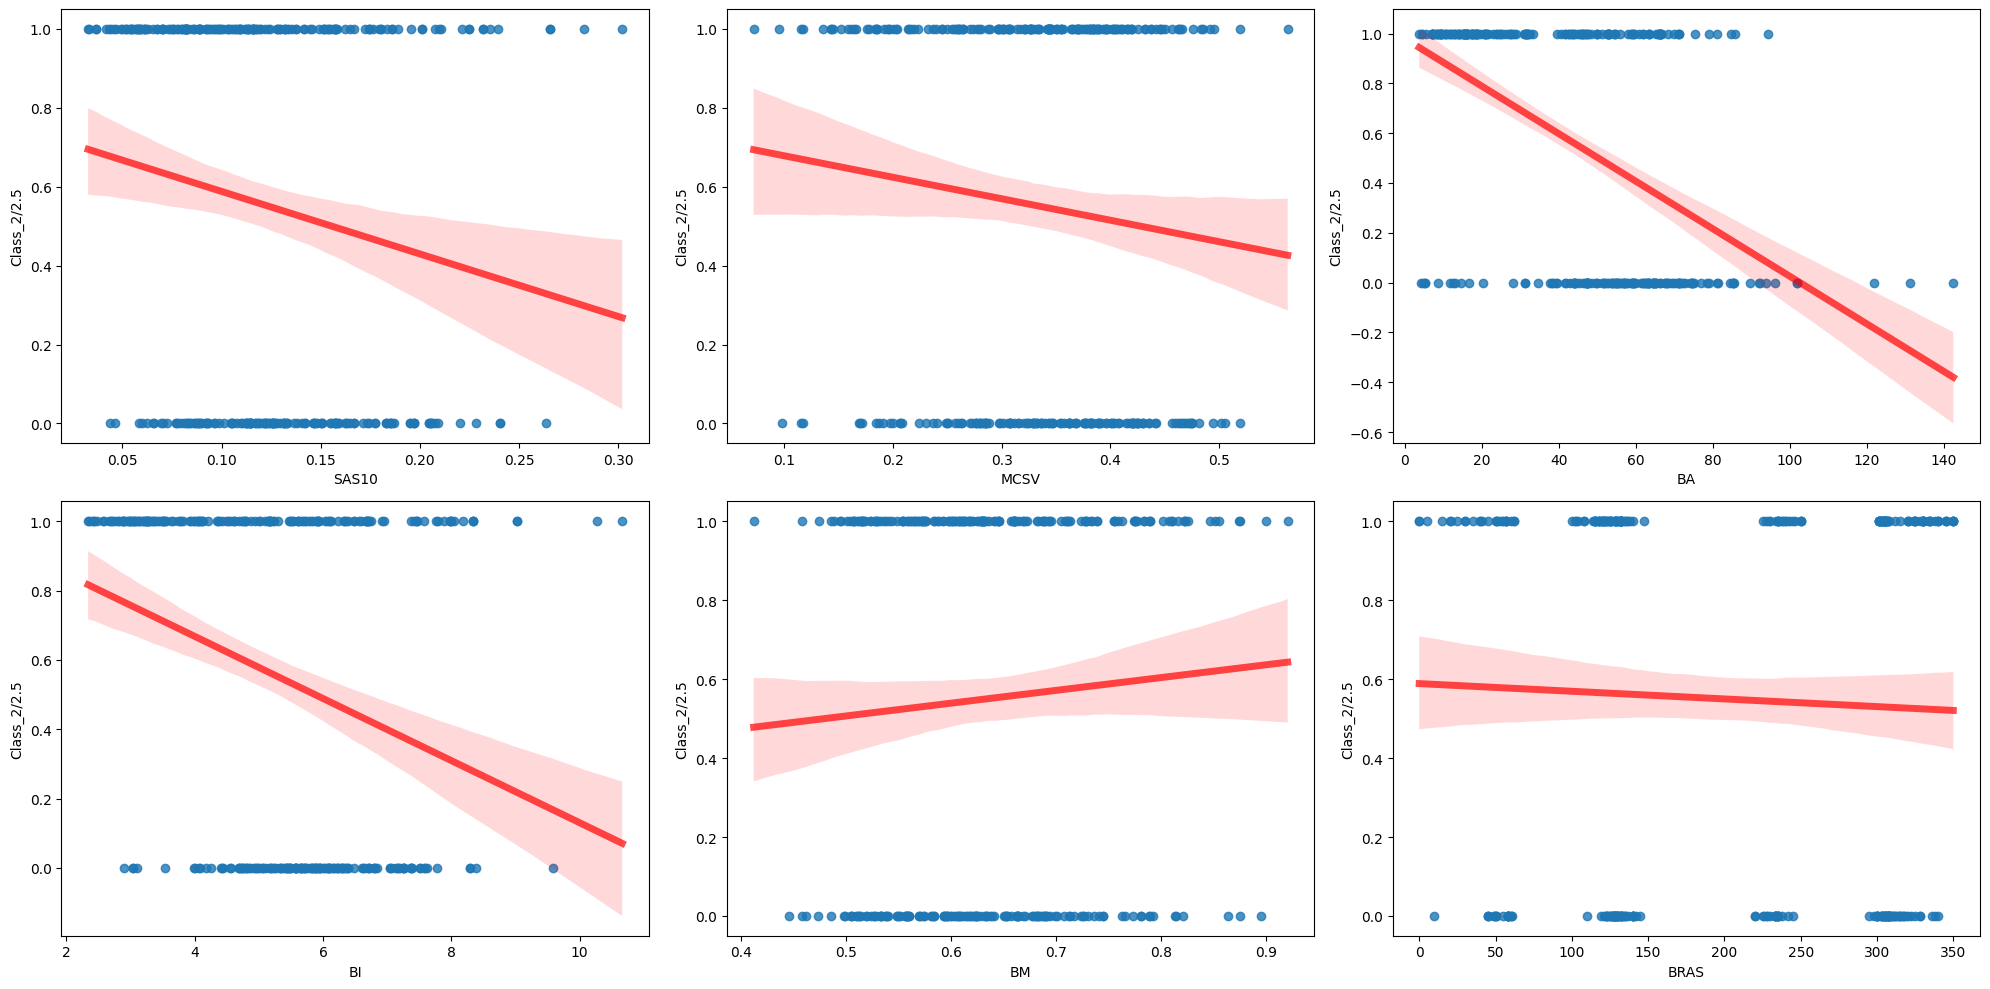

In [7]:
df = df_drop
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.regplot(x=df['SAS10'], y=df['Class_2/2.5'], data=df, ax=axs[0, 0], line_kws={"color":"r","alpha":0.7,"lw":5})
sns.regplot(x=df['MCSV'], y=df['Class_2/2.5'], data=df, ax=axs[0, 1], line_kws={"color":"r","alpha":0.7,"lw":5})
sns.regplot(x=df['BA'], y=df['Class_2/2.5'], ax=axs[0, 2], data=df, line_kws={"color":"r","alpha":0.7,"lw":5})
sns.regplot(x=df['BI'], y=df['Class_2/2.5'], data=df, ax=axs[1, 0], line_kws={"color":"r","alpha":0.7,"lw":5})
sns.regplot(x=df['BM'], y=df['Class_2/2.5'], data=df, ax=axs[1, 1], line_kws={"color":"r","alpha":0.7,"lw":5})
sns.regplot(x=df['BRAS'], y=df['Class_2/2.5'], data=df, ax=axs[1, 2], line_kws={"color":"r","alpha":0.7,"lw":5})

plt.tight_layout()
#fig.savefig("Correlation between variables and Class_2/2.5", dpi=400)
plt.show()

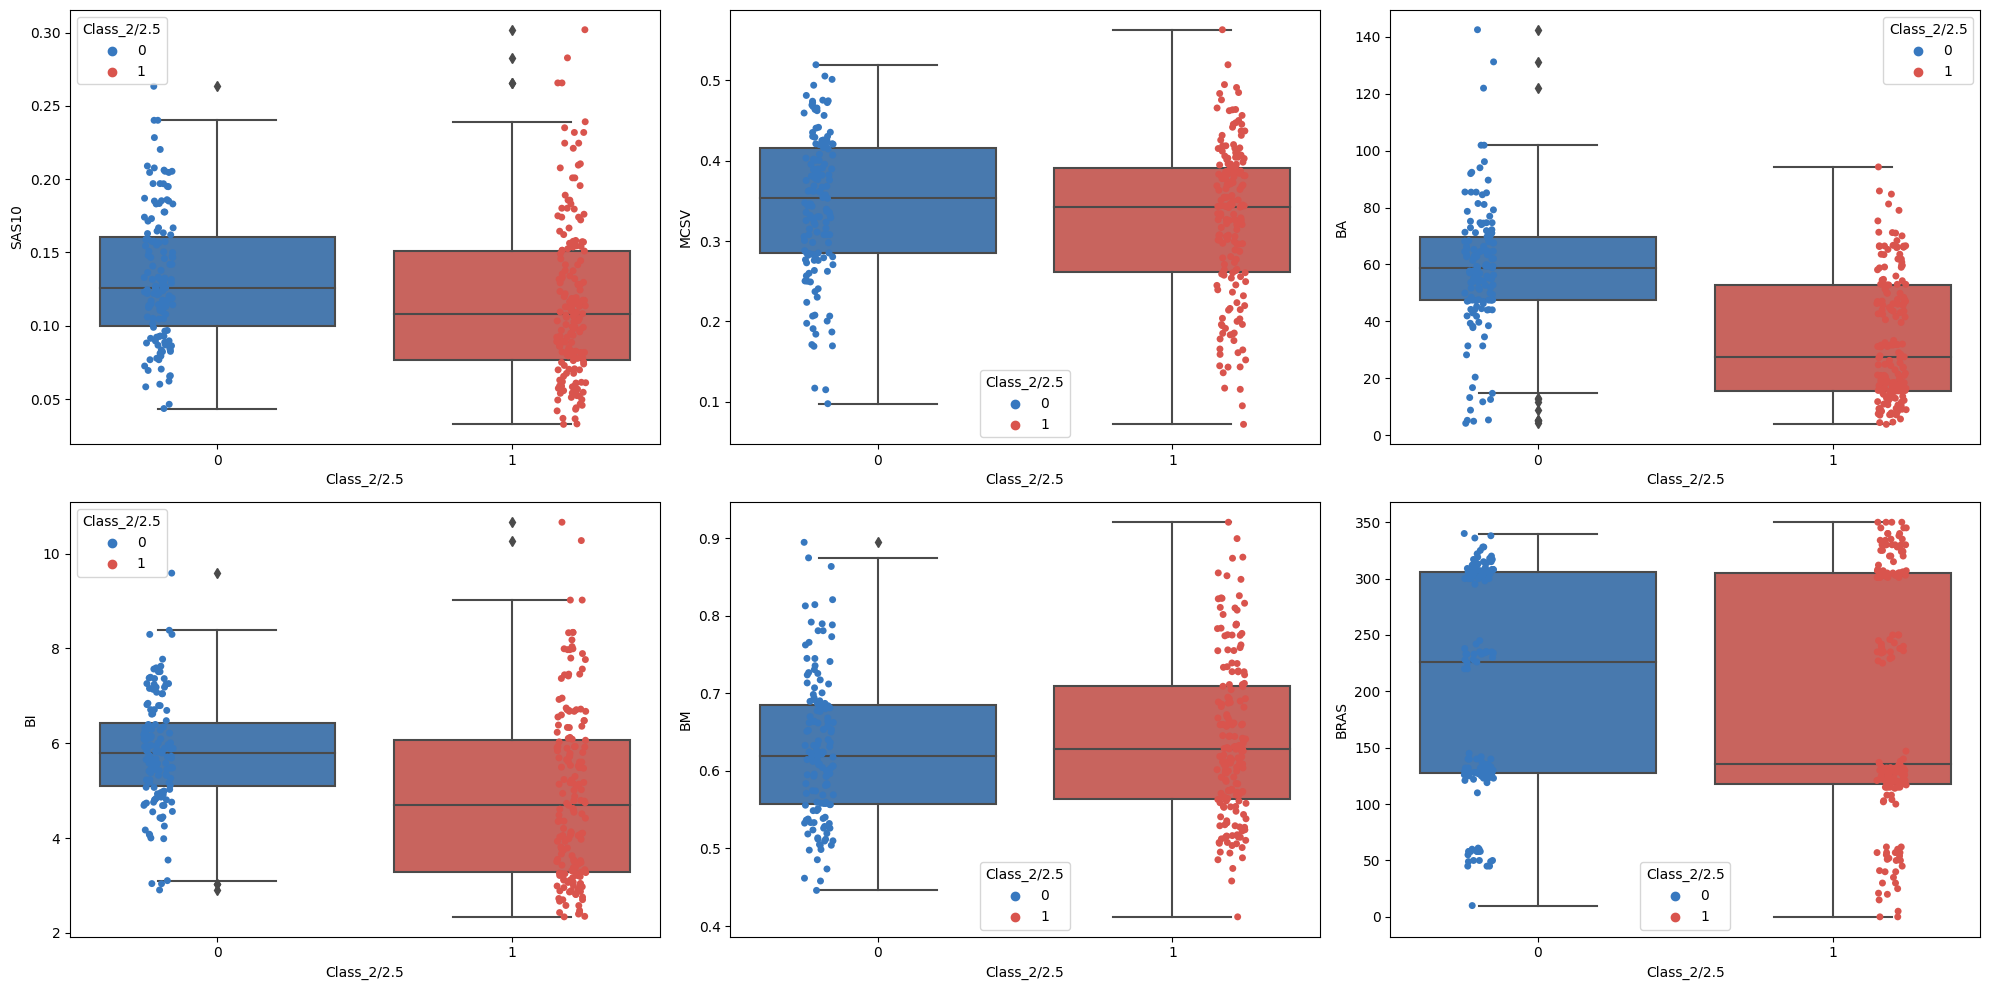

In [8]:
custom_palette = [sns.xkcd_rgb["windows blue"], sns.xkcd_rgb["pale red"], sns.xkcd_rgb["medium green"], "orange", "blue","yellow", "purple", "deeppink", "brown", "teal", "black"] 
sns.set_palette(custom_palette)

df = df_drop
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

sns.boxplot(x=df['Class_2/2.5'], y=df['SAS10'], data=df, ax=axs[0, 0], palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['SAS10'], ax=axs[0, 0], hue="Class_2/2.5", dodge=True)
sns.boxplot(x=df['Class_2/2.5'], y=df['MCSV'], data=df, ax=axs[0, 1], palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['MCSV'], ax=axs[0, 1], hue="Class_2/2.5", dodge=True)
sns.boxplot(x=df['Class_2/2.5'], y=df['BA'], ax=axs[0, 2], data=df, palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['BA'], ax=axs[0, 2], hue="Class_2/2.5", dodge=True)
sns.boxplot(x=df['Class_2/2.5'], y=df['BI'], data=df, ax=axs[1, 0], palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['BI'], ax=axs[1, 0], hue="Class_2/2.5", dodge=True)
sns.boxplot(x=df['Class_2/2.5'], y=df['BM'], data=df, ax=axs[1, 1], palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['BM'], ax=axs[1, 1], hue="Class_2/2.5", dodge=True)
sns.boxplot(x=df['Class_2/2.5'], y=df['BRAS'], data=df, ax=axs[1, 2], palette = custom_palette)
sns.stripplot(data=df,x=df['Class_2/2.5'], y=df['BRAS'], ax=axs[1, 2], hue="Class_2/2.5", dodge=True)

plt.tight_layout()
#fig.savefig("Differences between variables and Class_2-2.5.png", dpi=400)
plt.show()

In [9]:
def StudentTestSigni(df1,df2):
	"""Fonction permettant un test statistique classique (t test de student)"""
	student_test = ttest_ind(df1, df2)
	if student_test[1]< 0.05:
		print("Les valeurs sont significativement différentes (p = " + str(student_test[1]) + ")")
	elif student_test[1]> 0.05:
		print("Les valeurs ne sont pas significativement différentes (p = " + str(student_test[1]) + ")")

In [10]:
print("Pour SAS10")
StudentTestSigni(df[df['Class_2/2.5'] == False]["SAS10"], df[df['Class_2/2.5'] == True]["SAS10"])

print("Pour MCSV")
StudentTestSigni(df[df['Class_2/2.5'] == False]["MCSV"], df[df['Class_2/2.5'] == True]["MCSV"])

print("Pour BA")
StudentTestSigni(df[df['Class_2/2.5'] == False]["BA"], df[df['Class_2/2.5'] == True]["BA"])

print("Pour BI")
StudentTestSigni(df[df['Class_2/2.5'] == False]["BI"], df[df['Class_2/2.5'] == True]["BI"])

print("Pour BM")
StudentTestSigni(df[df['Class_2/2.5'] == False]["BM"], df[df['Class_2/2.5'] == True]["BM"])

print("Pour BRAS")
StudentTestSigni(df[df['Class_2/2.5'] == False]["BRAS"], df[df['Class_2/2.5'] == True]["BRAS"])

print("Pour COLLI")
StudentTestSigni(df[df['Class_2/2.5'] == False]["COLLI"], df[df['Class_2/2.5'] == True]["COLLI"])

Pour SAS10
Les valeurs sont significativement différentes (p = 0.003919681403573218)
Pour MCSV
Les valeurs ne sont pas significativement différentes (p = 0.07275522294012755)
Pour BA
Les valeurs sont significativement différentes (p = 4.499290385654683e-20)
Pour BI
Les valeurs sont significativement différentes (p = 1.8715722729095276e-07)
Pour BM
Les valeurs ne sont pas significativement différentes (p = 0.2576740283509029)
Pour BRAS
Les valeurs ne sont pas significativement différentes (p = 0.4741977039192802)
Pour COLLI
Les valeurs ne sont pas significativement différentes (p = 0.9033362554253825)


In [11]:
df_drop

,SAS10,MCSV,BA,BI,BM,BRAS,COLLI,Class_2.5/2.5,Class_3/3,Class_3/2,Class_2/3,Class_2/2.5
0,0.1204,0.2804,53.6566,5.3776,0.6849,129,345,0,1,0,1,0
1,0.1278,0.3143,52.8479,5.9211,0.6681,121,345,1,1,1,1,1
2,0.1572,0.3698,66.5478,6.4784,0.6078,305,20,1,1,1,1,1
3,0.1572,0.3698,66.5478,6.4784,0.6078,305,20,1,1,1,1,1
4,0.0457,0.4849,28.3954,2.9551,0.4953,235,15,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.0886,0.4837,16.4291,3.0396,0.4940,345,12,1,1,1,1,1
314,0.1169,0.3234,63.3976,5.9473,0.6636,140,350,0,1,0,1,0
315,0.1177,0.4071,74.6656,5.8371,0.5740,135,350,0,1,0,1,0
316,0.1082,0.3832,61.8779,5.7322,0.6037,301,10,1,1,1,1,1


### Il n'y aurait donc pas d'intérêt à prendre les variables non corrélées et non significativement différentes entre les classes -- ne garder que SAS10, BA et BI

In [ ]:
Y = df_drop['Class_2/2.5']
X = df_drop[['SAS10', 'BA', 'BI']]

In [ ]:
Y

In [ ]:
X_np   = np.array(X)
sc     = StandardScaler()
X_norm = sc.fit_transform(X_np)
X      = X_norm

In [ ]:
dump(sc, 'StandardScaler_SAS10_BA_BI.joblib')
dump(X, 'X_norm_SAS10_BA_BI.joblib')
dump(Y, 'Y_2-25.joblib')

In [ ]:
X = load('X_norm_SAS10_BA_BI.joblib')
Y = load('Y.joblib')

In [ ]:
X = load('X_norm.joblib')
Y = load('Y.joblib')

In [ ]:
Y

In [ ]:
X = df_drop[['BA']]

In [ ]:
Y['BA']=X

In [ ]:
X_np   = np.array(X)
sc     = StandardScaler()
X_norm = sc.fit_transform(X_np)
X      = X_norm

In [ ]:
np.mean(X)

In [ ]:
df = Y
print("Pour BA")
StudentTestSigni(df[df['Class_2/2.5'] == False]["BA"], df[df['Class_2/2.5'] == True]["BA"])

In [ ]:
df[df['Class_2/2.5'] == False]["BA"].mean()

In [ ]:
df[df['Class_2/2.5'] == True]["BA"].mean()